# In this notebook...

we demonstrate the use of our software in a multimodal setting ([MMASH cohort](https://physionet.org/content/mmash/1.0.0/)) where participants wore triaxial accelerometers and HR sensors concurrently. 

In this example, we show how our software can be used to derive sleep window inferences using either a [HR algorithm](https://www.medrxiv.org/content/10.1101/2020.09.05.20188367v1) or [angle-change algorithm](https://www.nature.com/articles/s41598-018-31266-z) using trixial accelerometer. 

Further, we show how these algorithms fair against sleep diaries in the same plot (vertical dotted lines) and present a modified [Bland-Altman plot](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4470095/) for the TST detected through the HR algorithm versus the sleep diary for the full MMASH cohort. 


In [1]:
from glob import glob
from hypnospy import Wearable, Experiment, Diary
from hypnospy.data import MMASHPreProcessing
from hypnospy.analysis import SleepBoudaryDetector, Viewer, SleepMetrics

In [2]:
# The abstraction experiment allows us to test many wearables at once
exp = Experiment()

In [3]:
# But, we still need to load the data for each wearable. For that, we iterate over a set of files in a directory with glob.
for file in glob("../data/examples_mmash/actigraph_*.csv"):
    pp = MMASHPreProcessing(file)
    w = Wearable(pp)  # Creates an Wearable from a pp object
    exp.add_wearable(w)  # Append it to the experiment

In [4]:
# Set frequency for every wearable in the collection
exp.set_freq_in_secs(5)

In [5]:
print("Loaded %d wearables." % (exp.size()))  # Prints out '22'

Loaded 3 wearables.


In [6]:
# Changing the hour the experiment starts from midnight (0) to 3pm (15)
exp.change_start_hour_for_experiment_day(15)

In [7]:
# Easily read the Diary information from a file on disk
diary = Diary().from_file("../data/examples_mmash/diary/mmash_diary.csv")
exp.add_diary(diary)

In [8]:
# Lets test different approaches for sleep boundaries (i.e., sleep onset/offset)
sbd = SleepBoudaryDetector(exp)
sbd.detect_sleep_boundaries(strategy="hr", output_col="hyp_sleep_period_hr", hr_quantile=0.35,
                            hr_sleep_search_window=(15, 15),
                            hr_min_window_length_in_minutes=35, hr_volatility_window_in_minutes=10,
                            hr_merge_blocks_gap_time_in_min=240,
                            hr_only_largest_sleep_period=True)

/home/palotti/p3/lib64/python3.8/site-packages/hypnospy-0.0.1-py3.8.egg/hypnospy/misc.py:51: UserWarning: Day has no sleep period!
/home/palotti/p3/lib64/python3.8/site-packages/hypnospy-0.0.1-py3.8.egg/hypnospy/misc.py:22: UserWarning: Day has no sleep period!


In [9]:
sbd.detect_sleep_boundaries(strategy="angle", output_col="hyp_sleep_period_angle_change",
                            angle_use_triaxial_activity=True,
                            angle_start_hour=15, angle_quantile=0.10, angle_minimum_len_in_minutes=30,
                            angle_merge_tolerance_in_minutes=60)

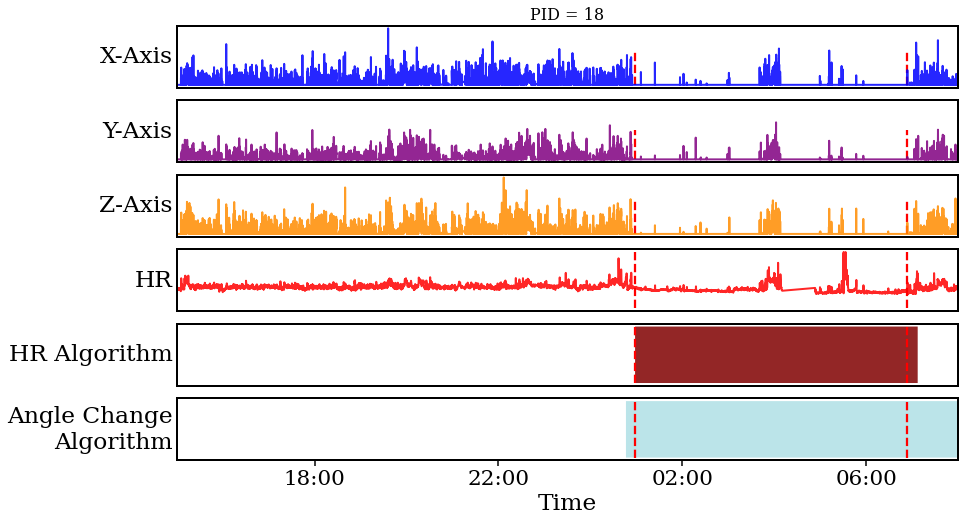

In [10]:
# We can visually inspect the boundaries generated by each algorithm:
v = Viewer(exp.get_wearable("18")) # 18
v.view_signals_multipanel(signals=["Axis1", "Axis2", "Axis3", "HR"], select_day=0, zoom=["15:00:00", "8:00:00"],
                          signals_as_area=["hyp_sleep_period_hr", "hyp_sleep_period_angle_change"], dashes_across=["hyp_diary_sleep"],
                          colors={"signal": ["blue", "purple", "darkorange", "red"],
                                  "area": ["maroon", "powderblue"], "dashes_across": "red"},
                          alphas={"signal": 0.85, "area": 0.85},
                          labels={"signal": ["X-Axis", "Y-Axis","Z-Axis", "HR"], "area": ["HR Algorithm", "Angle Change\nAlgorithm"]})

In [11]:
# v.view_signals(signal_categories=["activity", "sleep", "diary"],
#                sleep_cols=["hyp_sleep_period_hr", "hyp_sleep_period_angle_change"], select_days=[0])
# Or we can quantitatively measure how good is each algorithm for this dataset:
sm = SleepMetrics(exp)
results = sm.evaluate_sleep_boundaries(ground_truth="hyp_diary_sleep",
                                       others=["hyp_sleep_period_hr", "hyp_sleep_period_angle_change"])
# ``results'' is a dataframe in which each row compares the ground truth (hyp_diary_sleep) with each other strategy for sleep boundary
print(results["cohens_hyp_diary_sleep&hyp_sleep_period_angle_change"].mean())  # 0.730993
print(results["cohens_hyp_diary_sleep&hyp_sleep_period_hr"].mean())  # 0.785671

0.5970303976195649
0.738075518327189


<module 'matplotlib.pyplot' from '/home/palotti/p3/lib64/python3.8/site-packages/matplotlib/pyplot.py'>

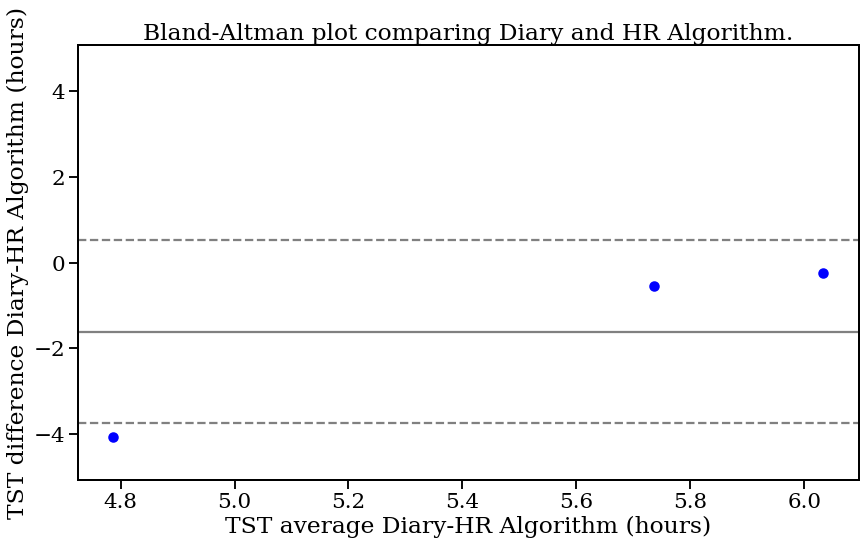

In [12]:
# Finally, we can plot a bland altman plot for each sleep onset/offset strategy
Viewer.plot_one_bland_altman(results, "hyp_diary_sleep", "hyp_sleep_period_hr",
                             label1="Diary", label2="HR Algorithm", plotname="blandaltman_hr.pdf")